## GlADE+ catalog visualization

In this notebook, we use the `healpy` library to visualize the data output from the `parse_catalog` script. We follow the tutorial provided in the [`healpy` documentation](https://healpy.readthedocs.io/en/latest/tutorial.html).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import healpy as hp

from catalog.utils import GalaxyCatalog, Skymap

In [2]:
# Notebook settings
save_figures = False

In [3]:
# Constants
nside = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        nside, hp.nside2resol(nside, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 32 is 1.8 deg


Number of pixels in the map:

In [4]:
npix = hp.nside2npix(nside)
npix

12288

Importing file:

In [5]:
catalog_path = '/Volumes/binadohd/phd/GLADE+/parsed_catalog.hdf5'
#catalog_path = '../data/GLADE+trimmed_parsed.hdf5'
catalog = GalaxyCatalog(catalog_path)

The `skymap` dataset holds the corresponding pixel for each galaxy. In the cell below, we convert this information into an array of length `npix` holding the number of galaxies within each pixel:

21882387 21882387


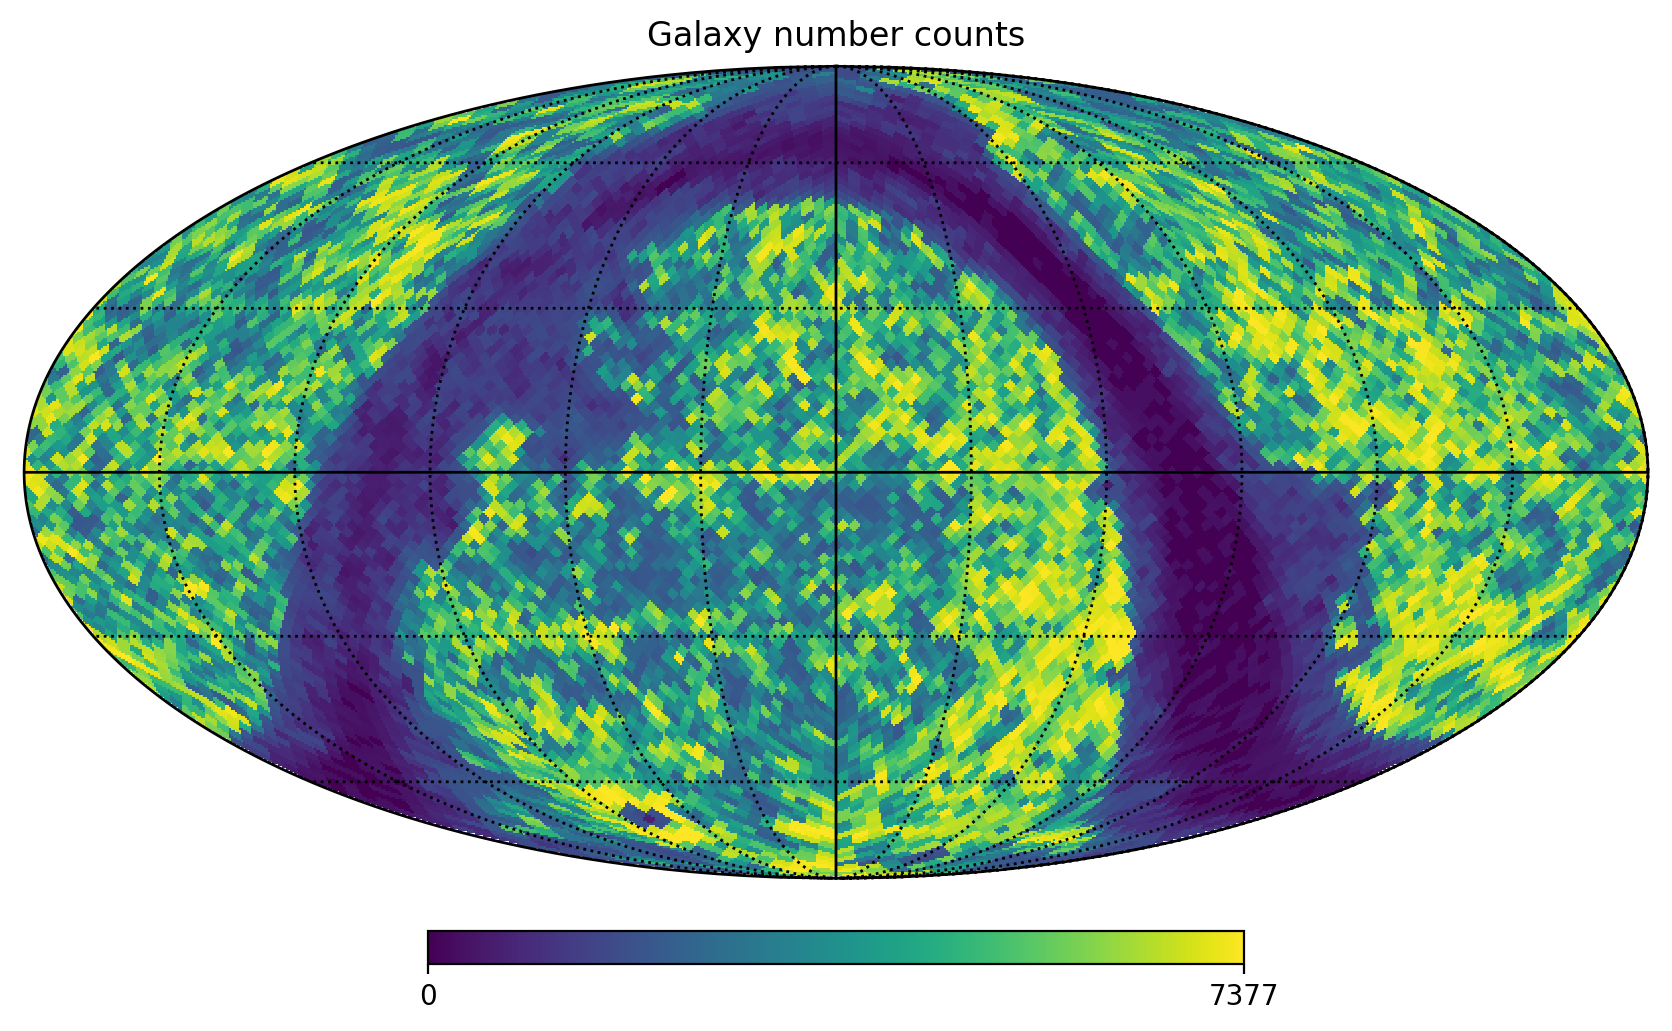

In [6]:
ra, dec = catalog.get('ra'), catalog.get('dec')
print(len(ra), len(dec))
skymap = Skymap(nside, ra, dec, nest=False)
number_density = skymap.counts()
hp.mollview(number_density, title="Galaxy number counts", norm="hist")
hp.graticule()
if save_figures:
    plt.savefig('figures/galaxy-map.png', dpi=400)
plt.show()

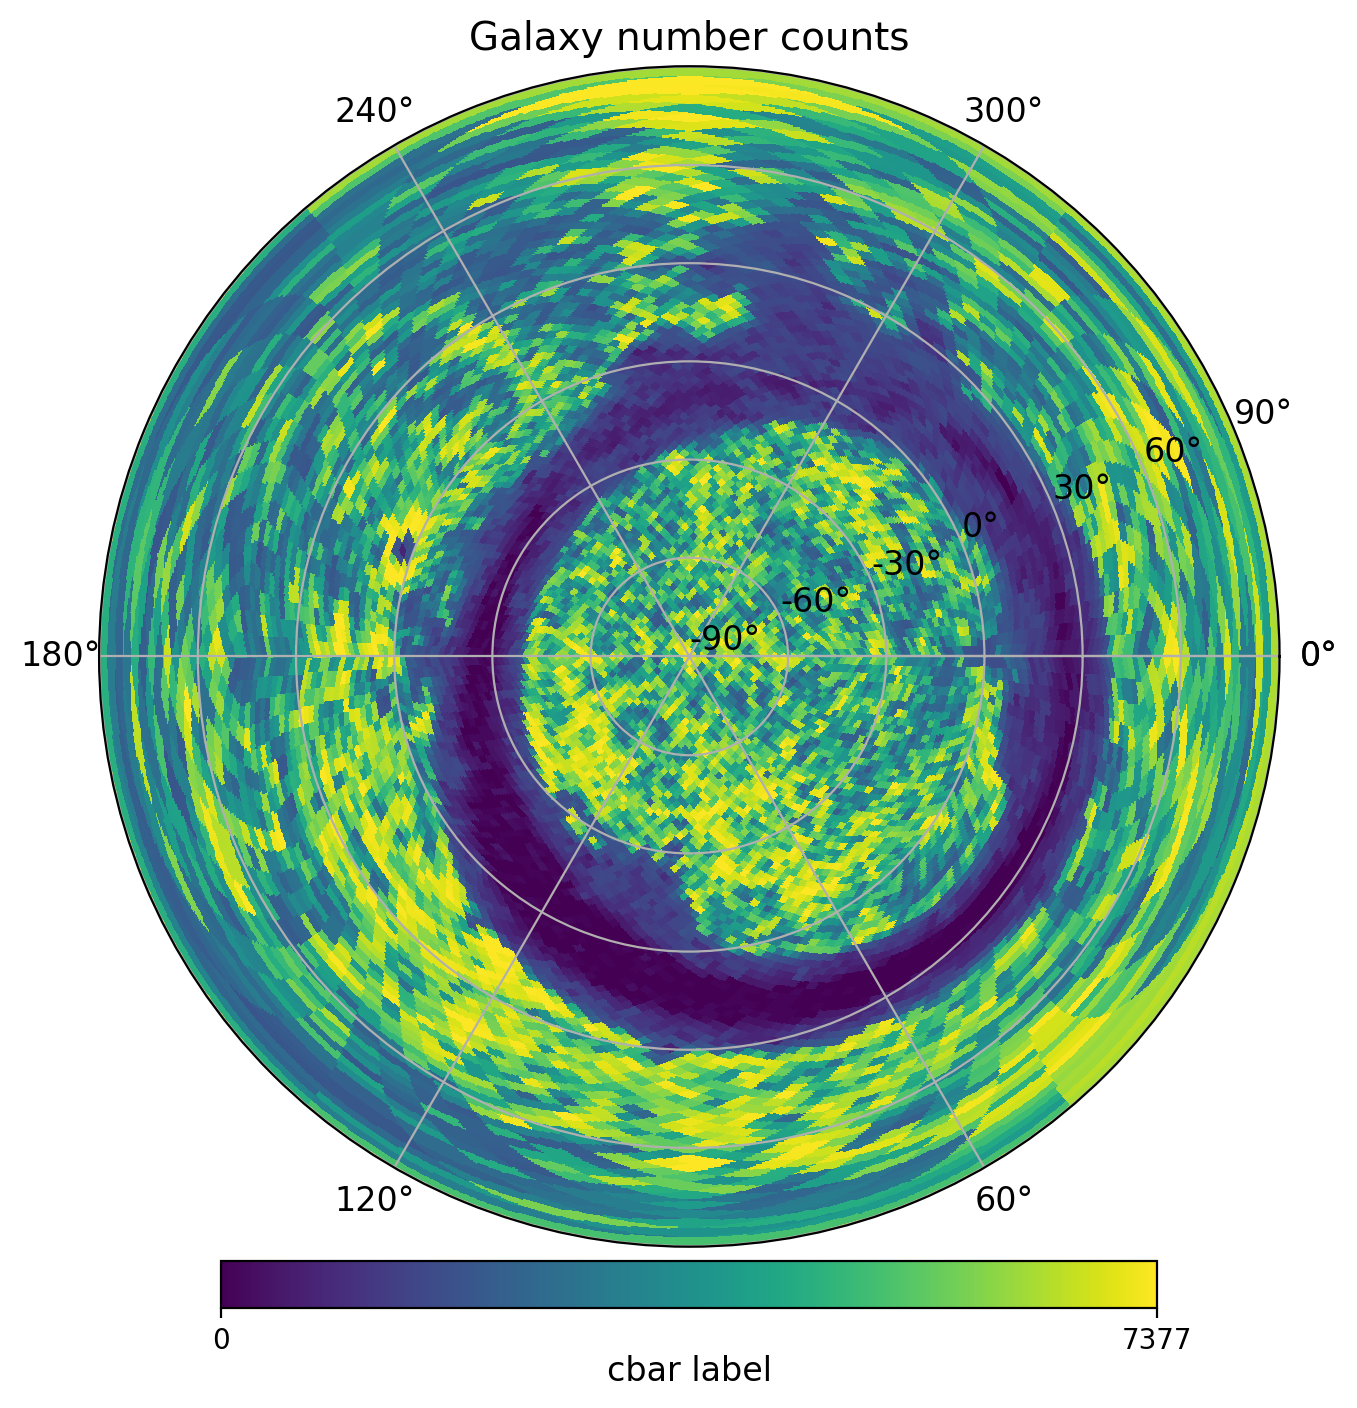

In [7]:
# polar view
hp.projview(
    number_density,
    coord=["G"],
    rot=[0, 90, 180],
    graticule=True,
    graticule_labels=True,
    unit="cbar label",
    norm="hist",
    cb_orientation="horizontal",
    projection_type="polar",
    title="Galaxy number counts",
)
plt.tight_layout()
plt.show()

Histogram of the redshift distribution:

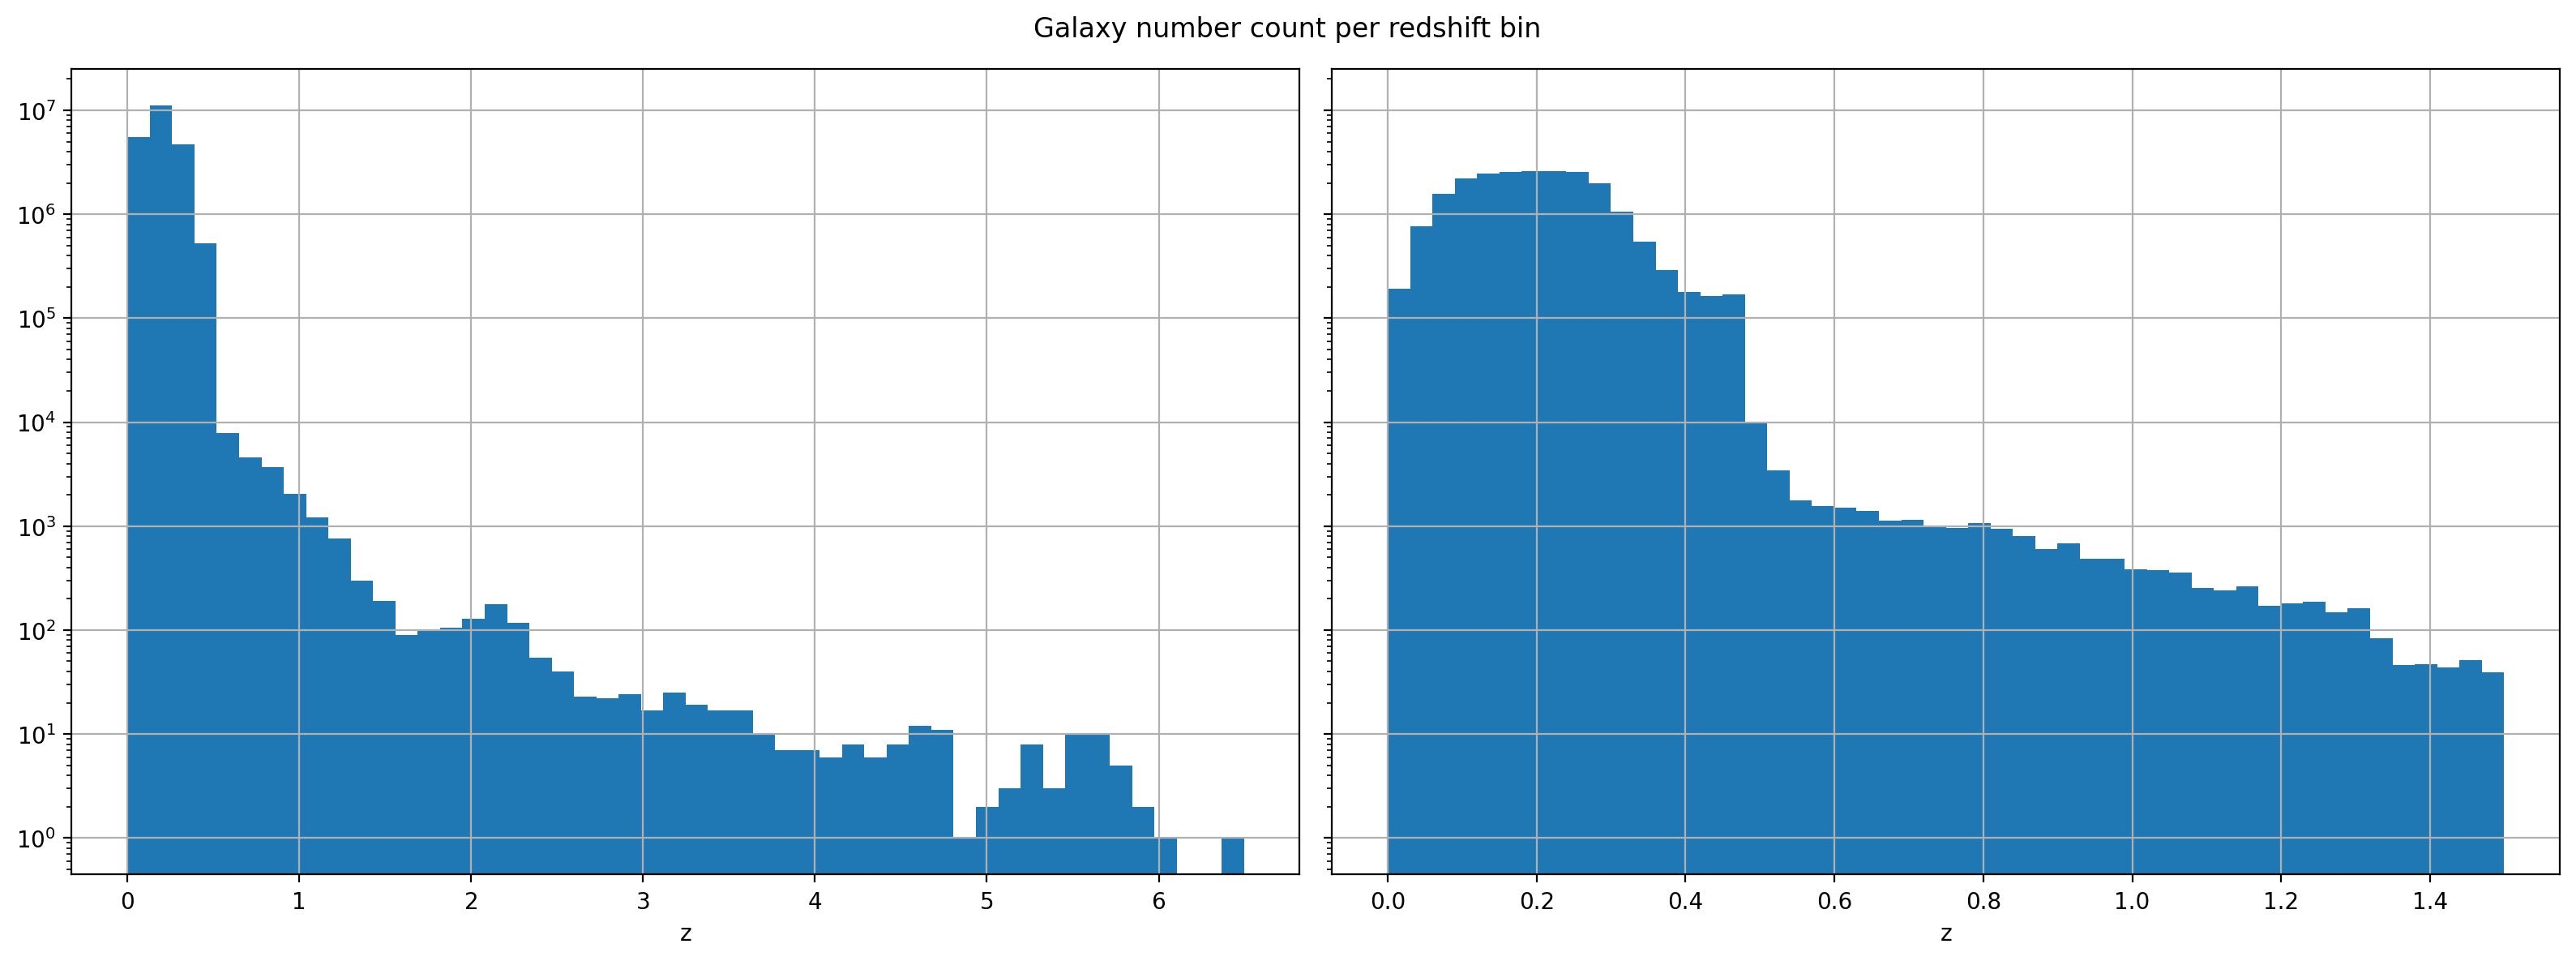

In [8]:
z = catalog.get('z_cmb')
z_max = 1.5
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
ax1.hist(z, bins=50, log=True)
ax2.hist(z[z < z_max], bins=50, log=True)
ax1.set_xlabel('z')
ax2.set_xlabel('z')
ax1.grid()
ax2.grid()
fig.suptitle('Galaxy number count per redshift bin')
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.tight_layout()
if save_figures:
    fig.savefig('figures/galaxy-redshift-distribution.png', dpi=400)
plt.show()

Mergers within galaxies at $z > 1.5$ are very unlikely to be detected by current-generation detectors. Let us repeat the plot upt to $z_{\text{max}}=1.5$:

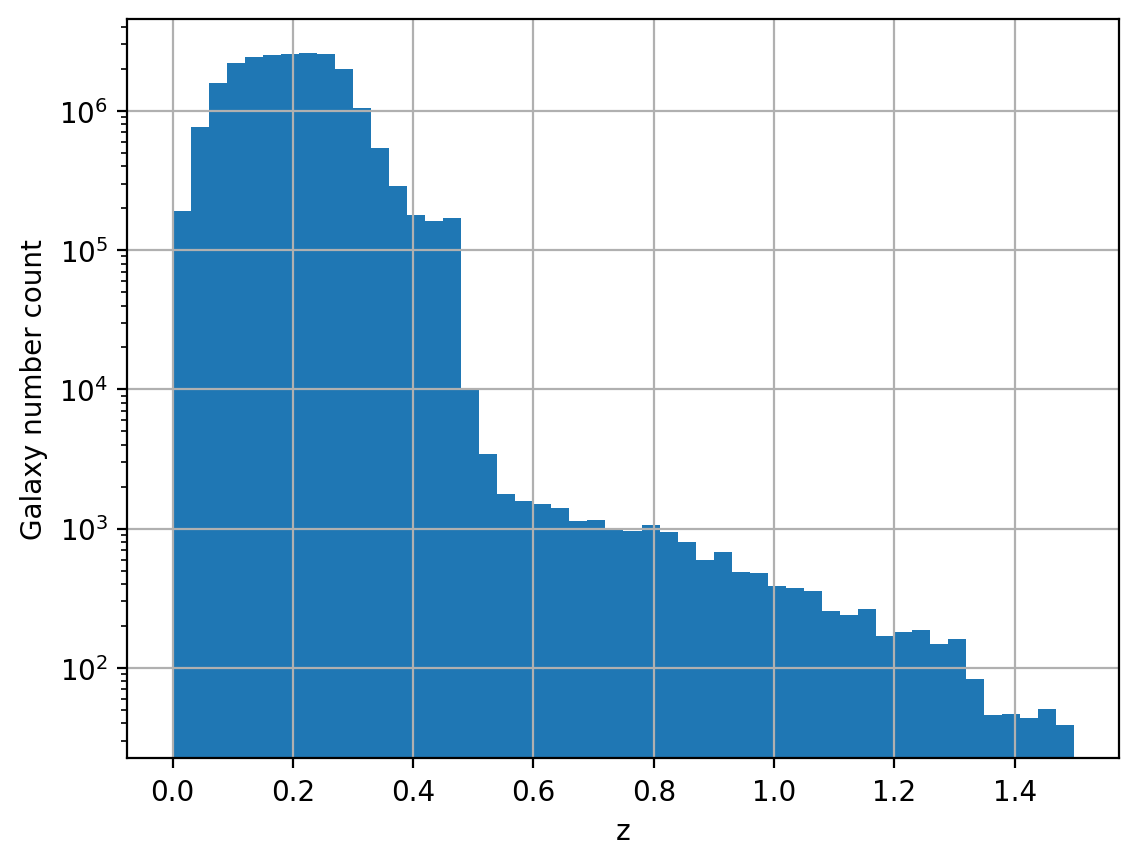

In [9]:
z = catalog.get('z_cmb')
plt.hist(z[z < 1.5], bins=50, log=True)
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.grid()
plt.show()

In [10]:
z_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
nbins = len(z_bins)
masks = skymap.bin_array(z, z_bins)
ra_per_bin  = [skymap.remove_mask(ra, ~mask) for mask in masks]
dec_per_bin  = [skymap.remove_mask(dec, ~mask) for mask in masks]
print([len(ra_per_bin[i]) for i in range(len(z_bins))])

[11429679, 9976901, 459452, 7838, 4469, 4048]


Below we plot the angular power spectrum for each redshift bin. We compute the $c_\ell$ using the HEALPIX `anafast` function after removing the monopole and dipole for stability. For each redshift bin, we plot $c_\ell$ and the rescaled $d_\ell = \ell (\ell + 1)c_\ell / 2\pi$. 

In [13]:
nside = 64
lmax = 3 * nside - 1
cls = np.empty((nbins + 1, lmax + 1))
# Compute angular power spectra for each redshift bin
for i, (rabin, decbin) in enumerate(zip(ra_per_bin, dec_per_bin)):
    bin_skymap = Skymap(nside, rabin, decbin, nest=False)
    binmap = bin_skymap.counts()
    binmap = hp.remove_dipole(np.array(binmap, dtype=np.float64))
    cls[i, :] = hp.anafast(binmap, lmax=lmax)

# Compute angular power spectra for the full catalog
fullmap = Skymap(nside, ra, dec, nest=False).counts()
fullmap = hp.remove_dipole(np.array(fullmap, dtype=np.float64))
cls[-1, :] = hp.anafast(fullmap, lmax=lmax)

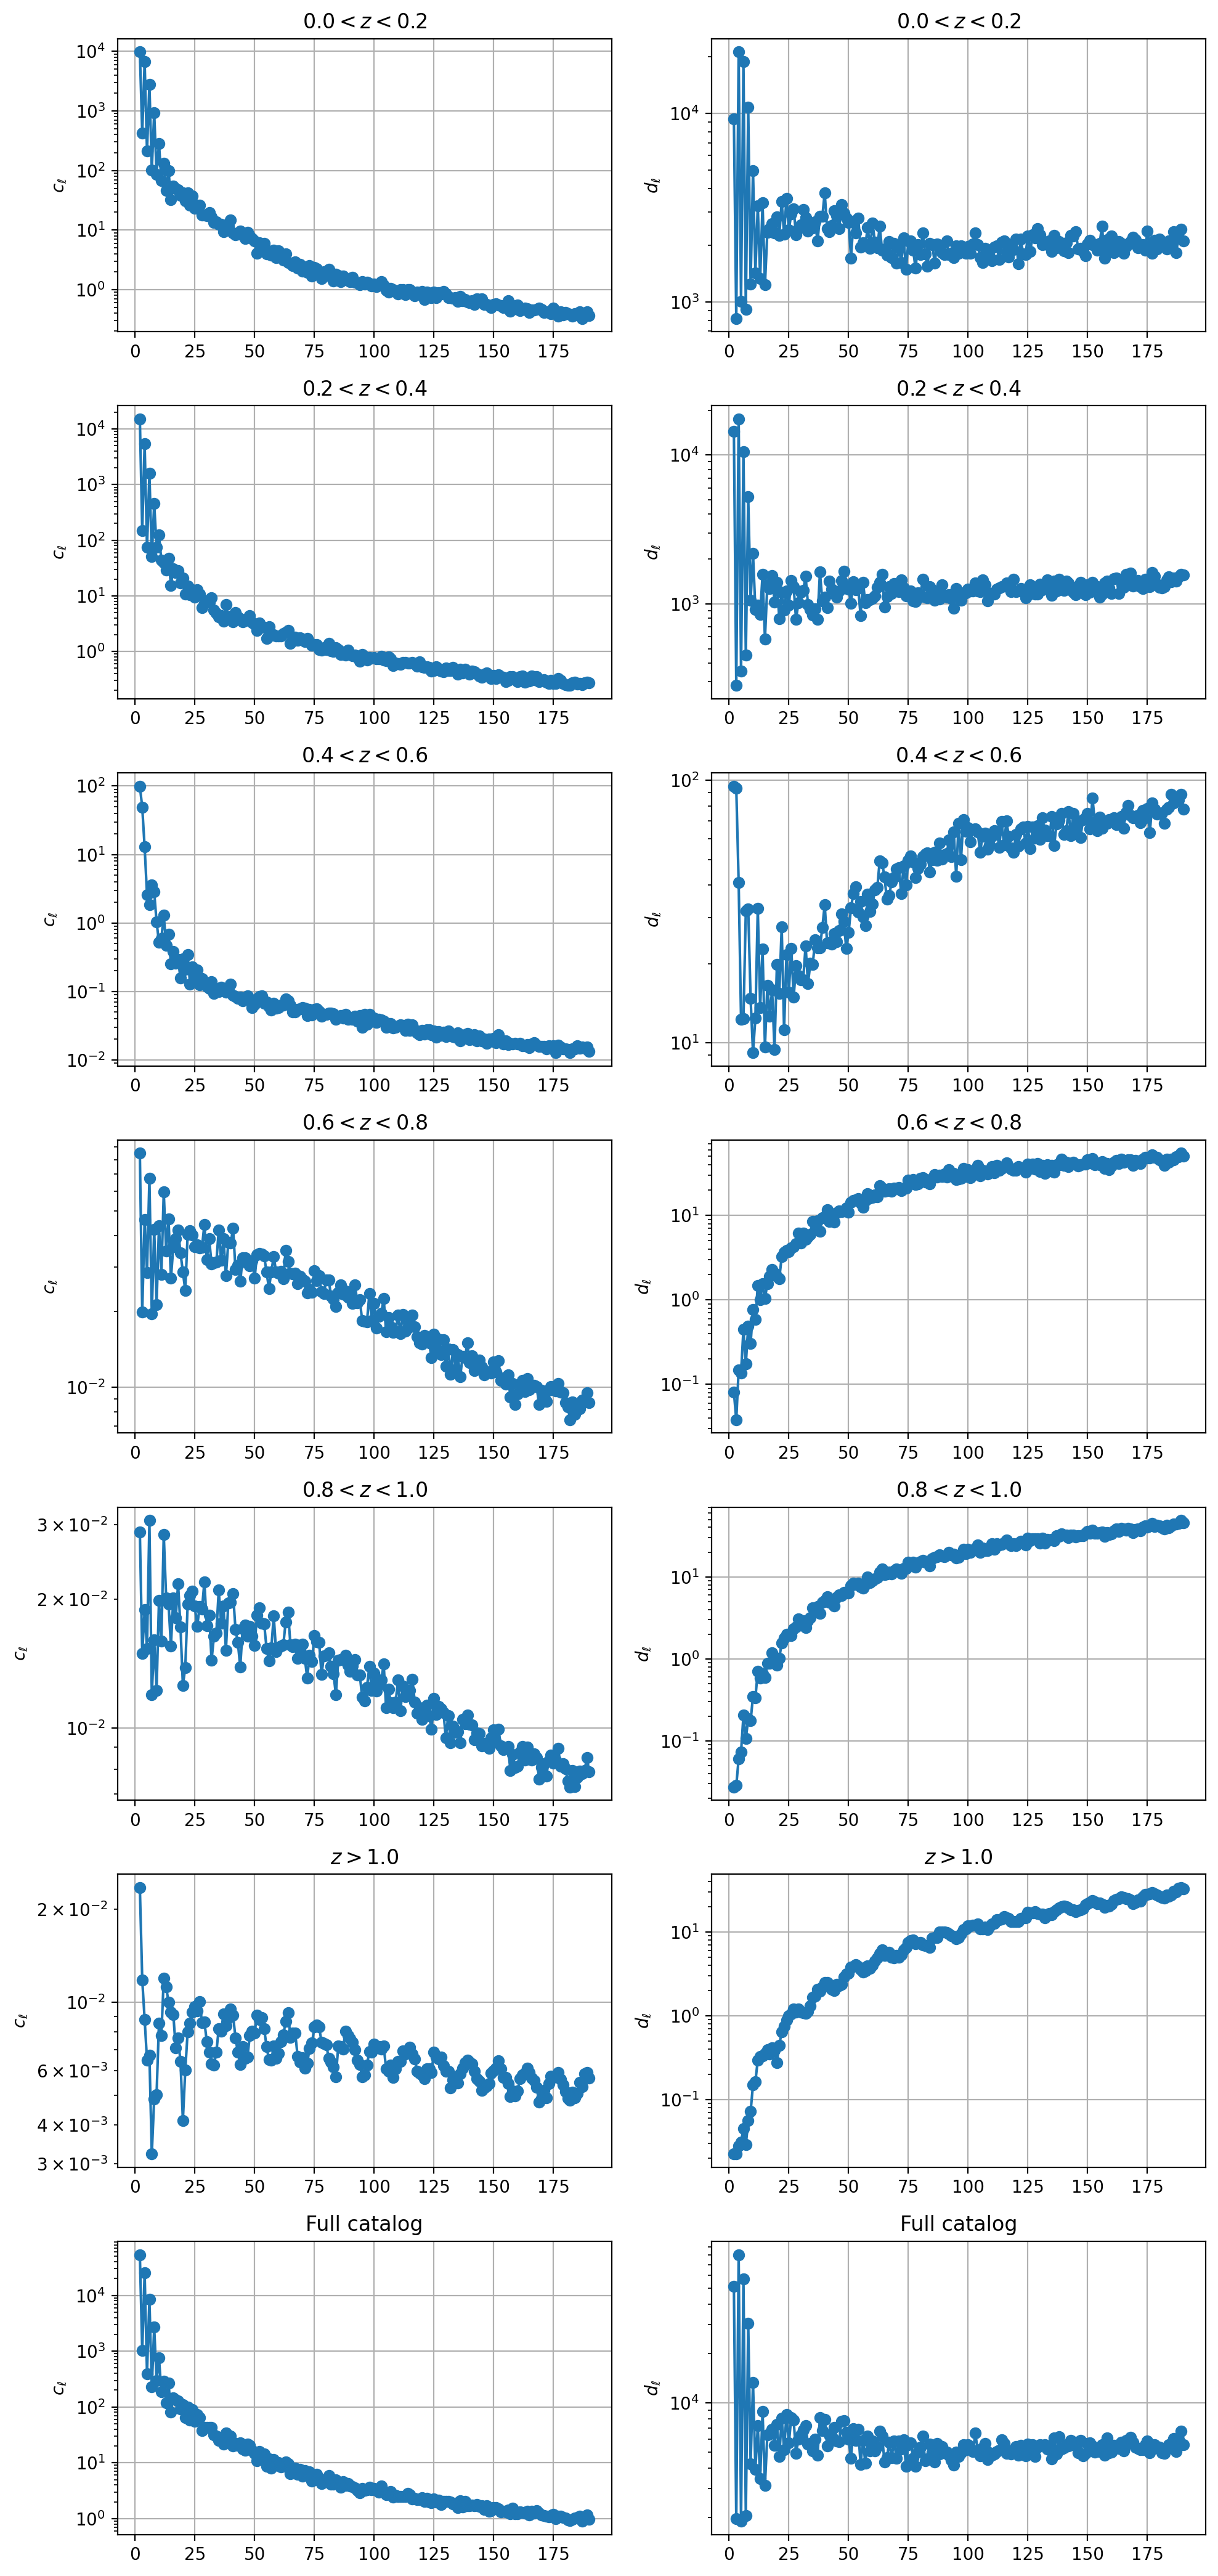

In [19]:
nside = 64
lmax = 3 * nside - 1
ell = np.arange(lmax + 1)
lshow = lmax
fig, axs = plt.subplots(nbins + 1, 2, figsize=(10, 3 * (nbins + 1)))

# Titles and labels
titles = [r'${} < z < {}$'.format(z_bins[i], z_bins[i + 1]) for i in range(nbins - 1)]
titles.append(r'$z > {}$'.format(z_bins[nbins - 1]))
titles.append('Full catalog')

for i, ax in enumerate(axs):
    ax[0].plot(ell[2:lshow], cls[i, 2:lshow], '-o')
    ax[1].plot(ell[2:lshow], (ell[2:lshow] * (ell[2:lshow] + 1) * cls[i, 2:lshow] / (2 * np.pi)), '-o')
    ax[0].set_title(titles[i])
    ax[1].set_title(titles[i])
    ax[0].set_ylabel(r'$c_\ell$')
    ax[1].set_ylabel(r'$d_\ell$')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].grid()
    ax[1].grid()
    
fig.tight_layout()
plt.show()